# Task 1

The images were taken roughly 1.5 inches apart from each other. 

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def full_task_1(img1, img2):
    gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp_1, des_1 = sift.detectAndCompute(gray_1, None)
    kp_2, des_2 = sift.detectAndCompute(gray_2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_1, des_2, k=2)

    good_matches = []
    pts_1 = []
    pts_2 = []

    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts_1.append(kp_1[m.queryIdx].pt)
            pts_2.append(kp_2[m.trainIdx].pt)

    pts_1 = np.float32(pts_1)
    pts_2 = np.float32(pts_2)

    print(f"Found {len(good_matches)} good matches")

    img_matches = cv2.drawMatches(
        img_1, kp_1, 
        img_2, kp_2, 
        good_matches[:20], 
        None, 
        matchesThickness=20, 
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # plt.figure(figsize=(15, 5))
    # plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    # plt.title("Feature Matches")
    # plt.axis('off')
    # plt.show()


    F, mask = cv2.findFundamentalMat(pts_1, pts_2, cv2.FM_RANSAC, 3, 0.99)
    print(f"Fundamental Matrix:\n{F}")

    pts_1_inliers = pts_1[mask.ravel() == 1]
    pts_2_inliers = pts_2[mask.ravel() == 1]

    def draw_epipolar_lines(img1, img2, lines, pts1, pts2):
        """Draw epipolar lines on img1 and corresponding points on both images"""
        r, c = img1.shape[:2]
        img1_color = img1.copy()
        img2_color = img2.copy()
        
        for r_line, pt1, pt2 in zip(lines[:20], pts1[:20], pts2[:20]):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r_line[2]/r_line[1]])
            x1, y1 = map(int, [c, -(r_line[2]+r_line[0]*c)/r_line[1]])
            img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 2)
            img1_color = cv2.circle(img1_color, tuple(map(int, pt2)), 20, color, -1)
            img2_color = cv2.circle(img2_color, tuple(map(int, pt1)), 20, color, -1)
        
        return img1_color, img2_color

    lines_2 = cv2.computeCorrespondEpilines(pts_1_inliers.reshape(-1, 1, 2), 1, F)
    lines_2 = lines_2.reshape(-1, 3)
    img_2_lines, img_1_pts = draw_epipolar_lines(img_2, img_1,   # SWAPPED!
                                                        lines_2, pts_1_inliers, 
                                                        pts_2_inliers)

    lines_1 = cv2.computeCorrespondEpilines(pts_2_inliers.reshape(-1, 1, 2), 2, F)
    lines_1 = lines_1.reshape(-1, 3)
    img_1_lines, img_2_pts = draw_epipolar_lines(img_1, img_2,    # SWAPPED!
                                                        lines_1, pts_2_inliers, 
                                                        pts_1_inliers)
    # fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    # axes[0, 0].imshow(cv2.cvtColor(img_1_lines, cv2.COLOR_BGR2RGB))
    # axes[0, 0].set_title("Epipolar Lines on 1 Image")
    # axes[0, 1].imshow(cv2.cvtColor(img_2_pts, cv2.COLOR_BGR2RGB))
    # axes[0, 1].set_title("Corresponding Points on 2 Image")
    # axes[1, 0].imshow(cv2.cvtColor(img_1_pts, cv2.COLOR_BGR2RGB))
    # axes[1, 0].set_title("Corresponding Points on 1 Image")
    # axes[1, 1].imshow(cv2.cvtColor(img_2_lines, cv2.COLOR_BGR2RGB))
    # axes[1, 1].set_title("Epipolar Lines on 2 Image")
    # for ax in axes.flat:
    #     ax.axis('off')
    # plt.tight_layout()
    # plt.savefig('epipolar_lines.png')
    # plt.show()

    gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

    window_size = 3
    min_disp = 0
    num_disp = 112 

    stereo_sgbm = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=50,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    disparity = stereo_sgbm.compute(gray_1, gray_2).astype(np.float32) / 16.0
    disparity_vis = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
    axes[0].set_title("1 Image")
    axes[1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
    axes[1].set_title("2 Image")
    axes[2].imshow(disparity_vis, cmap='jet')
    axes[2].set_title("Disparity Map (Hot = Close, Cold = Far)")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('disparity_simple.png')
    plt.show()

Found 1468 good matches
Fundamental Matrix:
[[-6.42583352e-08  1.64380022e-06 -1.79565133e-03]
 [-1.60962098e-06 -2.99465923e-07  2.05060035e-03]
 [ 5.75124845e-04 -1.42103514e-03  1.00000000e+00]]


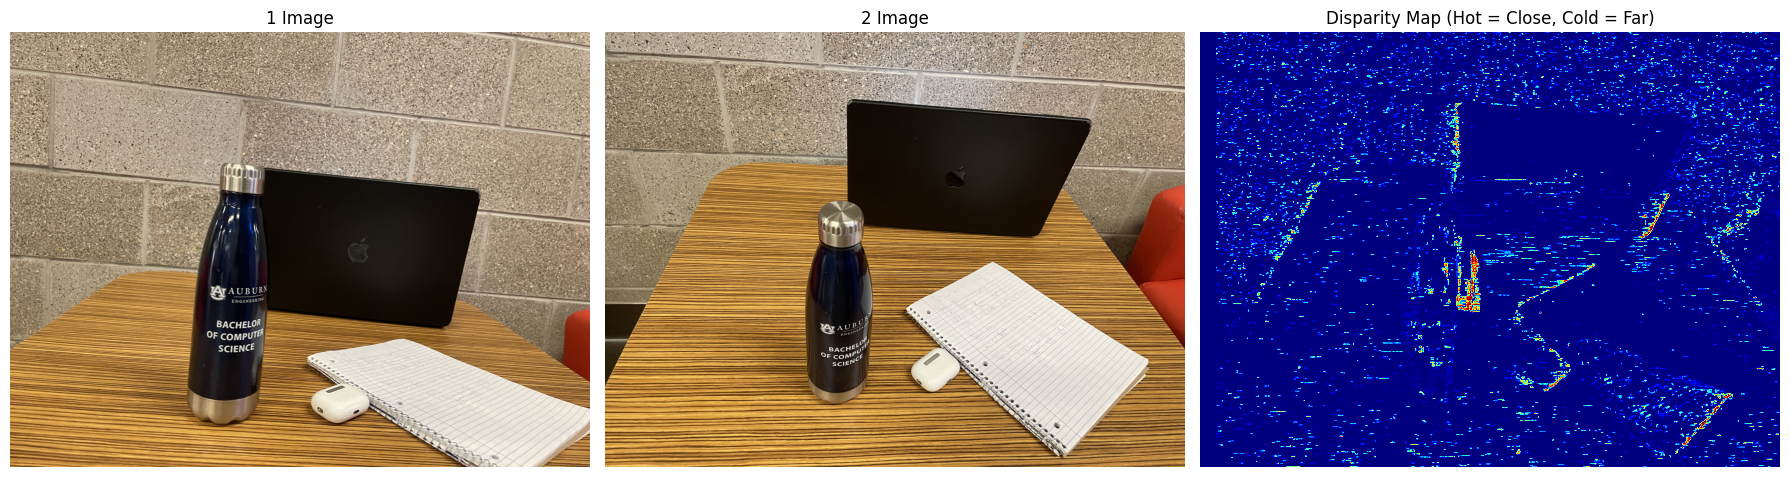

In [33]:
img_1 = cv2.imread('disparity_images/bottom.JPG')
img_2 = cv2.imread('disparity_images/top.JPG')

full_task_1(img_1, img_2)

Found 6259 good matches
Fundamental Matrix:
[[ 2.08810799e-08 -4.63488776e-06  4.49283877e-03]
 [ 4.64940170e-06  8.71355124e-08 -6.56693039e-03]
 [-4.33852573e-03  5.17460240e-03  1.00000000e+00]]


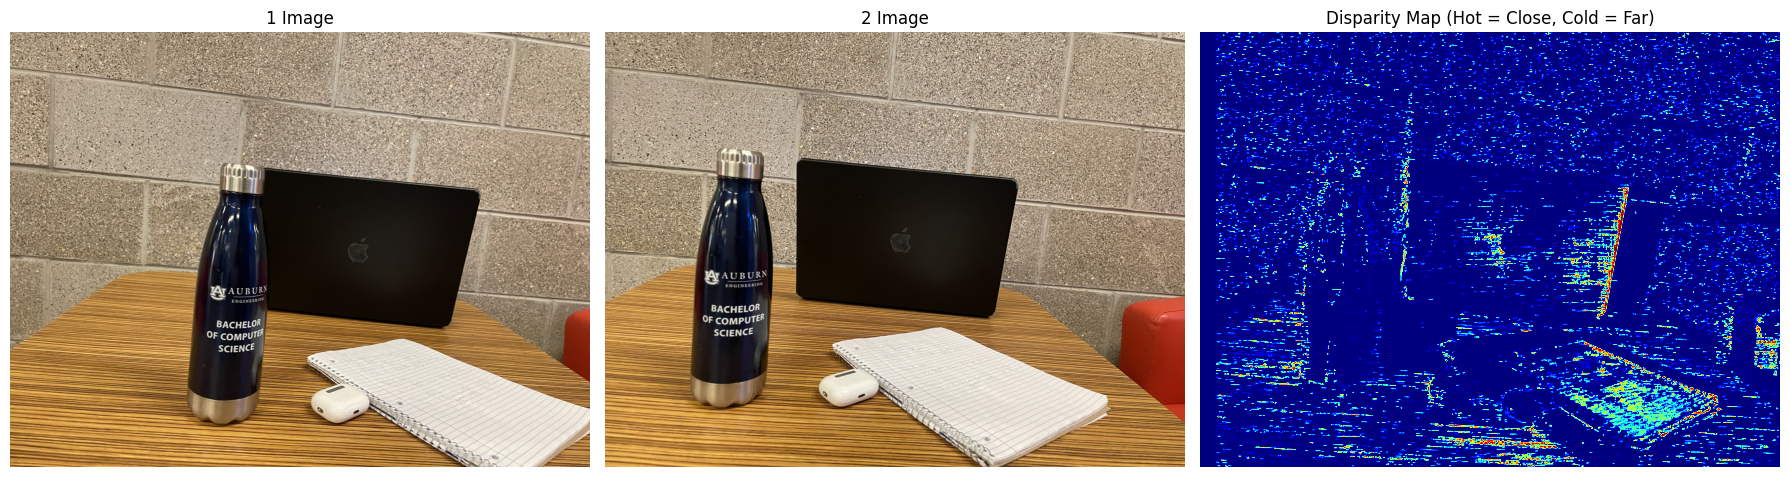

In [34]:
img_1 = cv2.imread('disparity_images/bottom.JPG')
img_2 = cv2.imread('disparity_images/distance_1_inch.JPG')

full_task_1(img_1, img_2)

Found 5103 good matches
Fundamental Matrix:
[[-2.08027244e-08 -1.26711722e-06  3.79542548e-03]
 [ 1.40104254e-06  4.00493400e-08 -7.76913003e-03]
 [-3.85781274e-03  6.90796144e-03  1.00000000e+00]]


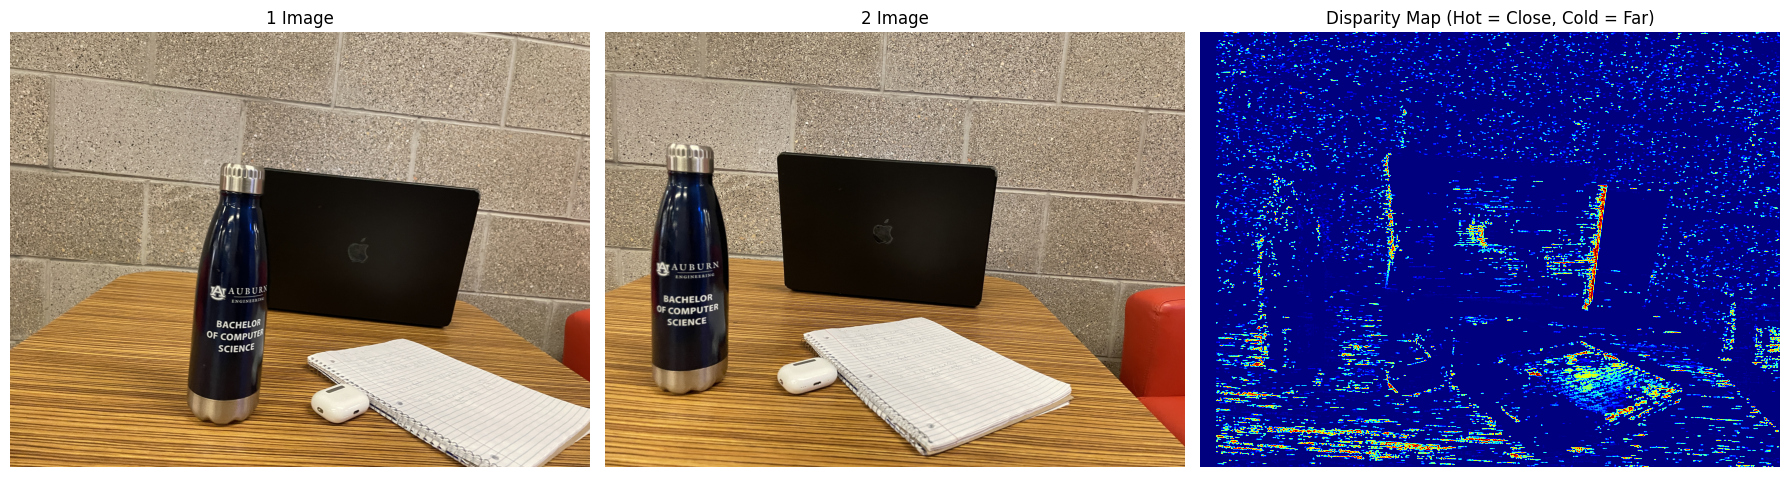

In [28]:
img_1 = cv2.imread('disparity_images/bottom.JPG')
img_2 = cv2.imread('disparity_images/distance_4_inches.JPG')

full_task_1(img_1, img_2)

d. Analyze how baseline distance and camera orientation affect
disparity quality.

I used three different image pairs. A left right pair that was ~1 inch apart, a left/right pair that was ~4 inches apart and a vertically seperated pair that was about ~5 inches apart. Both left right pairs were decently accurate. The 4 inch separated pair was marginally better than the 1 inch pair. The top/down pair was the least accurate.

a. How did you ensure camera alignment?

I tried my best to ensure that my phone camera stayed as level as possible.

b. Did the disparity map make sense?

The disparity map succesfully showed that the binder was the closest to the camera. However, it did show a significanty amount of noise on the wall. 

c. What happens if the baseline is very small or too large?

If the baseline is too small, it is not possible to accurately determine the depth of the objects. If the baseline is too large, it can be difficult to match features across the images and a disparity map can not be made.


# Task 2

Image size: (1200, 900)
Image 0: 11982 keypoints
Image 1: 10853 keypoints
Image 2: 11431 keypoints
Image 3: 12481 keypoints
Image 4: 14001 keypoints
Matches 0->1: 2673
Matches 1->2: 2265
Matches 2->3: 2525
Matches 3->4: 2714

Camera matrix K:
[[900.   0. 450.]
 [  0. 900. 600.]
 [  0.   0.   1.]]

=== Processing first pair ===
Point pairs: 2673
Essential matrix inliers: 2181/2673 (81.6%)
Pose recovery inliers: 2181/2673
Triangulated: 2181 points
  Reprojection filter: 2181/2181 points kept
  Mean error: 0.19, 0.20

=== Processing pair 1->2 ===
Point pairs: 2265
Essential matrix inliers: 2032/2265 (89.7%)
Pose recovery inliers: 2032/2265
Triangulated: 2032 points
  Reprojection filter: 2031/2032 points kept
  Mean error: 5.44, 5.67

=== Processing pair 2->3 ===
Point pairs: 2525
Essential matrix inliers: 2365/2525 (93.7%)
Pose recovery inliers: 2365/2525
Triangulated: 2365 points
  Reprojection filter: 2272/2365 points kept
  Mean error: 4.95, 4.85

=== Processing pair 3->4 ===
Point pa

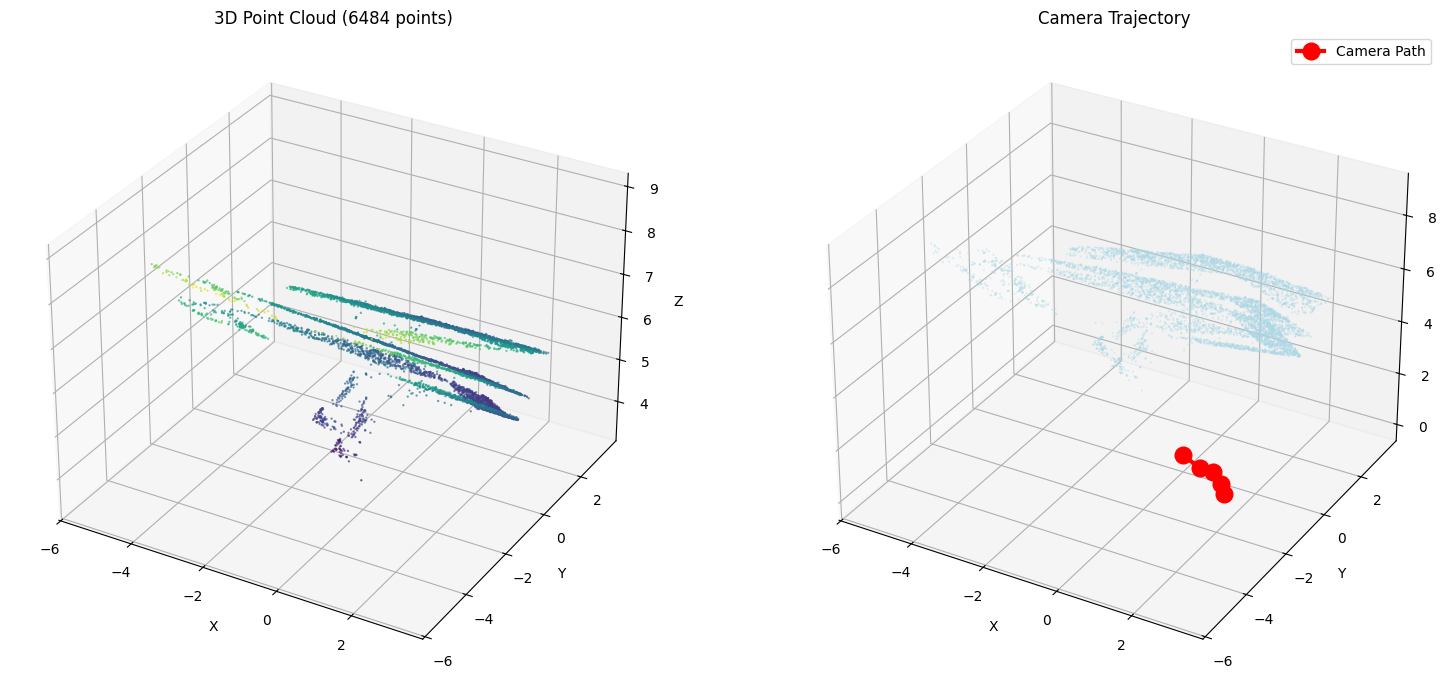

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load images
img1 = cv2.imread('task2/IMG_6932.JPG')
img2 = cv2.imread('task2/IMG_6933.JPG')
img3 = cv2.imread('task2/IMG_6934.JPG')
img4 = cv2.imread('task2/IMG_6935.JPG')
img5 = cv2.imread('task2/IMG_6936.JPG')

images = [img1, img2, img3, img4, img5]

# Resize images if they're huge (helps with processing)
max_dim = 1200
resized_images = []
for img in images:
    h, w = img.shape[:2]
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        img = cv2.resize(img, (new_w, new_h))
    resized_images.append(img)

images = resized_images
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

print(f"Image size: {gray_images[0].shape}")

# Extract SIFT features
sift = cv2.SIFT_create(nfeatures=0, contrastThreshold=0.04, edgeThreshold=10)
keypoints_list = []
descriptors_list = []

for i, gray in enumerate(gray_images):
    kp, des = sift.detectAndCompute(gray, None)
    keypoints_list.append(kp)
    descriptors_list.append(des)
    print(f"Image {i}: {len(kp)} keypoints")

# Match with BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches_list = []

for i in range(len(descriptors_list) - 1):
    matches = bf.knnMatch(descriptors_list[i], descriptors_list[i+1], k=2)
    
    # Lowe's ratio test
    good_matches = []
    for pair in matches:
        if len(pair) == 2:
            m, n = pair
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
    
    matches_list.append(good_matches)
    print(f"Matches {i}->{i+1}: {len(good_matches)}")

# Camera matrix
h, w = gray_images[0].shape
focal = w  # Rough estimate
K = np.array([[focal, 0, w/2],
              [0, focal, h/2],
              [0, 0, 1]], dtype=np.float64)

print(f"\nCamera matrix K:\n{K}")

def get_matched_points(kp1, kp2, matches):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    return pts1, pts2

# Process first pair
print("\n=== Processing first pair ===")
pts1, pts2 = get_matched_points(keypoints_list[0], keypoints_list[1], matches_list[0])
print(f"Point pairs: {len(pts1)}")

# Essential matrix with RANSAC
E, mask_e = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
inliers_e = np.sum(mask_e)
print(f"Essential matrix inliers: {inliers_e}/{len(pts1)} ({100*inliers_e/len(pts1):.1f}%)")

# Recover pose
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K, mask=mask_e)
inliers_pose = np.sum(mask_pose)
print(f"Pose recovery inliers: {inliers_pose}/{len(pts1)}")

# Initialize poses
poses = [np.hstack([np.eye(3), np.zeros((3, 1))])]
poses.append(np.hstack([R, t]))

# Triangulate
pts1_good = pts1[mask_pose.ravel() == 1]
pts2_good = pts2[mask_pose.ravel() == 1]

P1 = K @ poses[0]
P2 = K @ poses[1]

points_4d = cv2.triangulatePoints(P1, P2, pts1_good.T, pts2_good.T)
points_3d = (points_4d[:3] / points_4d[3]).T

print(f"Triangulated: {len(points_3d)} points")

# Check reprojection error and filter
def check_reprojection(points_3d, pts1, pts2, P1, P2, threshold=8.0):
    # Reproject to both images
    points_4d_h = np.hstack([points_3d, np.ones((len(points_3d), 1))]).T
    
    proj1 = P1 @ points_4d_h
    proj1 = proj1[:2] / proj1[2]
    
    proj2 = P2 @ points_4d_h
    proj2 = proj2[:2] / proj2[2]
    
    error1 = np.linalg.norm(pts1.T - proj1, axis=0)
    error2 = np.linalg.norm(pts2.T - proj2, axis=0)
    
    # Check if in front of both cameras
    depths1 = (P1 @ points_4d_h)[2]
    depths2 = (P2 @ points_4d_h)[2]
    
    mask = (error1 < threshold) & (error2 < threshold) & (depths1 > 0) & (depths2 > 0)
    
    print(f"  Reprojection filter: {np.sum(mask)}/{len(points_3d)} points kept")
    print(f"  Mean error: {np.mean(error1[mask]):.2f}, {np.mean(error2[mask]):.2f}")
    
    return points_3d[mask], mask

points_3d, good_mask = check_reprojection(points_3d, pts1_good, pts2_good, P1, P2)
all_points = [points_3d]

# Process remaining pairs
for i in range(1, len(matches_list)):
    print(f"\n=== Processing pair {i}->{i+1} ===")
    
    pts1, pts2 = get_matched_points(keypoints_list[i], keypoints_list[i+1], matches_list[i])
    print(f"Point pairs: {len(pts1)}")
    
    E, mask_e = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    inliers_e = np.sum(mask_e)
    print(f"Essential matrix inliers: {inliers_e}/{len(pts1)} ({100*inliers_e/len(pts1):.1f}%)")
    
    _, R_rel, t_rel, mask_pose = cv2.recoverPose(E, pts1, pts2, K, mask=mask_e)
    inliers_pose = np.sum(mask_pose)
    print(f"Pose recovery inliers: {inliers_pose}/{len(pts1)}")
    
    # Compose pose
    prev_R = poses[-1][:, :3]
    prev_t = poses[-1][:, 3:4]
    new_R = prev_R @ R_rel
    new_t = prev_R @ t_rel + prev_t
    poses.append(np.hstack([new_R, new_t]))
    
    # Triangulate
    pts1_good = pts1[mask_pose.ravel() == 1]
    pts2_good = pts2[mask_pose.ravel() == 1]
    
    P1 = K @ poses[i]
    P2 = K @ poses[i+1]
    
    points_4d = cv2.triangulatePoints(P1, P2, pts1_good.T, pts2_good.T)
    points_3d_new = (points_4d[:3] / points_4d[3]).T
    
    print(f"Triangulated: {len(points_3d_new)} points")
    
    # Filter by reprojection
    points_3d_new, good_mask = check_reprojection(points_3d_new, pts1_good, pts2_good, P1, P2)
    
    if len(points_3d_new) > 0:
        all_points.append(points_3d_new)

# Combine all points
all_points_combined = np.vstack(all_points)
print(f"\n=== TOTAL: {len(all_points_combined)} points ===")

# Visualize
fig = plt.figure(figsize=(16, 7))

# Point cloud
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(all_points_combined[:, 0], all_points_combined[:, 1], all_points_combined[:, 2], 
            c=all_points_combined[:, 2], cmap='viridis', marker='.', s=2, alpha=0.6)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'3D Point Cloud ({len(all_points_combined)} points)')

# Camera trajectory
ax2 = fig.add_subplot(122, projection='3d')
camera_centers = np.array([-pose[:, :3].T @ pose[:, 3] for pose in poses])

ax2.plot(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], 
         'r-o', linewidth=3, markersize=12, label='Camera Path')

ax2.scatter(all_points_combined[:, 0], all_points_combined[:, 1], all_points_combined[:, 2], 
            c='lightblue', marker='.', s=1, alpha=0.4)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Camera Trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

# Visualize matches
# fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# for idx in range(min(4, len(matches_list))):
#     ax = axes[idx // 2, idx % 2]
#     match_img = cv2.drawMatches(images[idx], keypoints_list[idx], 
#                                  images[idx+1], keypoints_list[idx+1], 
#                                  matches_list[idx][:50], None,
#                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#     ax.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
#     ax.set_title(f'Matches {idx}->{idx+1} (showing 50/{len(matches_list[idx])})')
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

a. Did your reconstruction look realistic?

The reconstruction looked vaguely like the original image. It picked up on the outline of the laptop, but mainly focused on the texture of the carpet underneath.

b. What kinds of motion caused errors or degenerate
configurations?

The main motion-related error I observed was from accumulating errors across consecutive images. The final pair of images contained significantly more errors than the first pair. 

c. What were your main failure modes?

I originally tried to make my object a smooth lego minifigure on a plain, uniform colored background. This totally didn't work at all because there were not enough features to match with SIFT. By changing the object to my laptop on a textured background, I was able to dramatically improve performance. 

# Task 3

Found 5072 good matches
Fundamental Matrix:
[[ 5.57677370e-08 -2.53567169e-06  3.68146984e-03]
 [ 2.61701269e-06  1.06238746e-07 -8.56608383e-03]
 [-3.80687718e-03  7.37305972e-03  1.00000000e+00]]
[Disparity Coverage] 10.2%  (valid 1249493 / total 12192768)
[Disparity Smoothness] std = 39.328  (lower is better)
[Good Matches] 5072


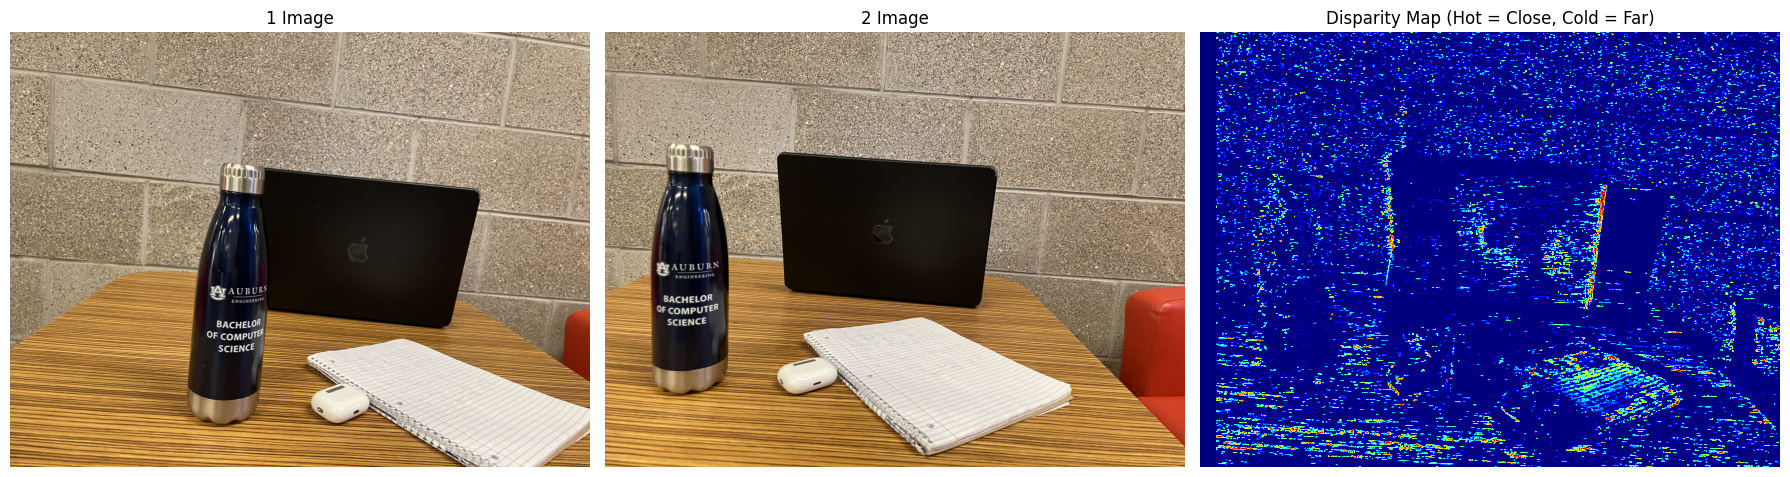

---Using calibration---
Found 5254 good matches
Fundamental Matrix:
[[ 9.27128496e-08 -3.11938683e-06  3.62213439e-03]
 [ 3.13226354e-06  1.58965284e-07 -7.03910297e-03]
 [-3.68146905e-03  5.74518647e-03  1.00000000e+00]]
[Disparity Coverage] 10.9%  (valid 1332472 / total 12192768)
[Disparity Smoothness] std = 38.900  (lower is better)
[Good Matches] 5254


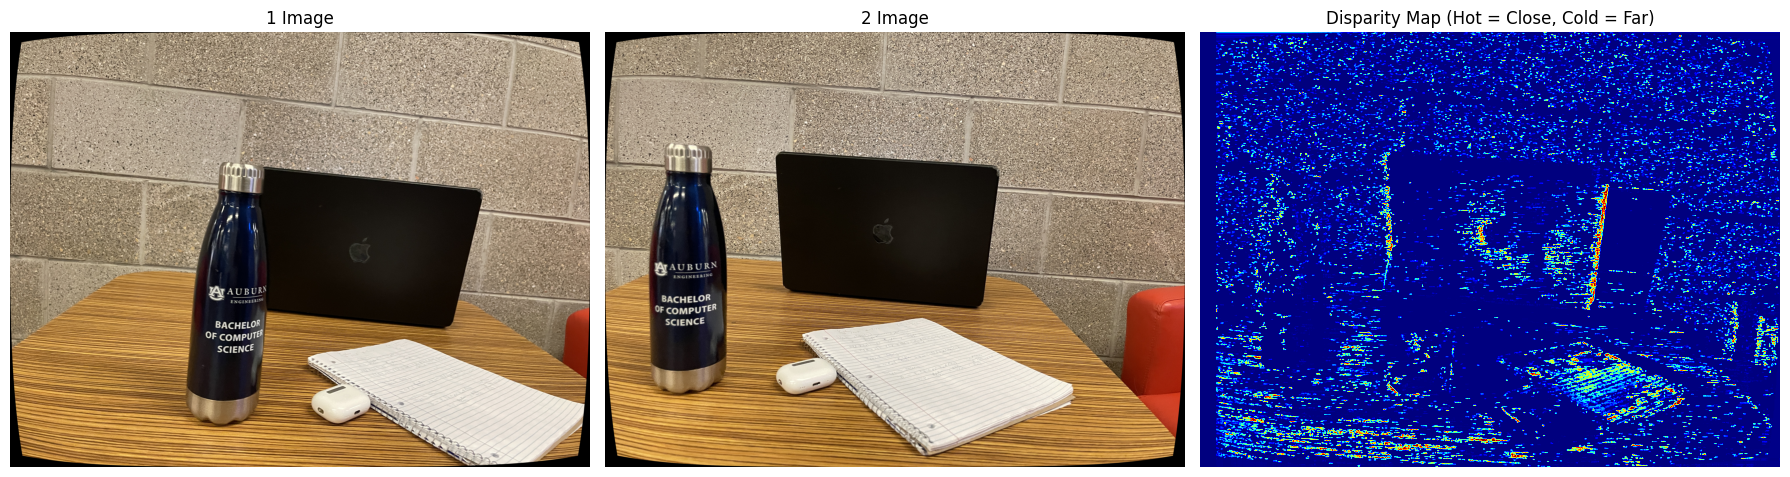

In [65]:
# ---- Minimal calibration added; rest of your pipeline is unchanged ----
import cv2, numpy as np
import matplotlib.pyplot as plt



def full_task_1(img1, img2, use_calib=True):
    img_1, img_2 = img1, img2

    # --- calibration only ---
    if use_calib:
        print("---Using calibration---")
        intr = np.load("intrinsics_phone.npz")
        K, dist = intr["K"], intr["dist"]

        def undistort(img, K, dist):
            h, w = img.shape[:2]
            newK, _ = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1.0, (w, h))
            map1, map2 = cv2.initUndistortRectifyMap(K, dist, None, newK, (w, h), cv2.CV_32FC1)
            return cv2.remap(img, map1, map2, cv2.INTER_LINEAR)

        img_1 = undistort(img_1, K, dist)
        img_2 = undistort(img_2, K, dist)        

    gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp_1, des_1 = sift.detectAndCompute(gray_1, None)
    kp_2, des_2 = sift.detectAndCompute(gray_2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_1, des_2, k=2)

    good_matches = []
    pts_1 = []
    pts_2 = []

    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts_1.append(kp_1[m.queryIdx].pt)
            pts_2.append(kp_2[m.trainIdx].pt)

    pts_1 = np.float32(pts_1)
    pts_2 = np.float32(pts_2)

    print(f"Found {len(good_matches)} good matches")

    img_matches = cv2.drawMatches(
        img_1, kp_1,
        img_2, kp_2,
        good_matches[:20],
        None,
        matchesThickness=20,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # plt.figure(figsize=(15, 5))
    # plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    # plt.title("Feature Matches")
    # plt.axis('off')
    # plt.show()

    F, mask = cv2.findFundamentalMat(pts_1, pts_2, cv2.FM_RANSAC, 3, 0.99)
    print(f"Fundamental Matrix:\n{F}")

    pts_1_inliers = pts_1[mask.ravel() == 1]
    pts_2_inliers = pts_2[mask.ravel() == 1]

    def draw_epipolar_lines(img1, img2, lines, pts1, pts2):
        """Draw epipolar lines on img1 and corresponding points on both images"""
        r, c = img1.shape[:2]
        img1_color = img1.copy()
        img2_color = img2.copy()

        for r_line, pt1, pt2 in zip(lines[:20], pts1[:20], pts2[:20]):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r_line[2] / r_line[1]])
            x1, y1 = map(int, [c, -(r_line[2] + r_line[0] * c) / r_line[1]])
            img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 2)
            img1_color = cv2.circle(img1_color, tuple(map(int, pt2)), 20, color, -1)
            img2_color = cv2.circle(img2_color, tuple(map(int, pt1)), 20, color, -1)

        return img1_color, img2_color

    lines_2 = cv2.computeCorrespondEpilines(pts_1_inliers.reshape(-1, 1, 2), 1, F)
    lines_2 = lines_2.reshape(-1, 3)
    img_2_lines, img_1_pts = draw_epipolar_lines(
        img_2, img_1,  # SWAPPED!
        lines_2, pts_1_inliers,
        pts_2_inliers
    )

    lines_1 = cv2.computeCorrespondEpilines(pts_2_inliers.reshape(-1, 1, 2), 2, F)
    lines_1 = lines_1.reshape(-1, 3)
    img_1_lines, img_2_pts = draw_epipolar_lines(
        img_1, img_2,  
        lines_1, pts_2_inliers,
        pts_1_inliers
    )

    gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_1 = clahe.apply(gray_1)
    gray_2 = clahe.apply(gray_2)
    gray_1 = cv2.GaussianBlur(gray_1, (3,3), 0)
    gray_2 = cv2.GaussianBlur(gray_2, (3,3), 0)

    window_size = 3
    min_disp = 0
    num_disp = 112

    stereo_sgbm = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=50,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    disparity = stereo_sgbm.compute(gray_1, gray_2).astype(np.float32) / 16.0
    disparity_vis = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


    # ==== ADDED METRICS ====
    valid_mask = disparity > 0
    total_px   = disparity.size
    valid_px   = int(np.count_nonzero(valid_mask))
    coverage   = 100.0 * valid_px / total_px if total_px else 0.0

    smoothness = float(np.std(disparity[valid_mask])) if valid_px else float("nan")

    good_match_count = len(good_matches)

    print(f"[Disparity Coverage] {coverage:.1f}%  (valid {valid_px} / total {total_px})")
    print(f"[Disparity Smoothness] std = {smoothness:.3f}  (lower is better)")
    print(f"[Good Matches] {good_match_count}")
    # =======================

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
    axes[0].set_title("1 Image")
    axes[1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
    axes[1].set_title("2 Image")
    axes[2].imshow(disparity_vis, cmap='jet')
    axes[2].set_title("Disparity Map (Hot = Close, Cold = Far)")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    # plt.savefig(f'disparity_images/callibrated_distance4')
    plt.show()

# img_1 = cv2.imread('disparity_images/bottom.JPG')
# img_2 = cv2.imread('disparity_images/top.JPG')

# full_task_1(img_1, img_2)

# img_1 = cv2.imread('disparity_images/bottom.JPG')
# img_2 = cv2.imread('disparity_images/distance_1_inch.JPG')

# full_task_1(img_1, img_2)

img_1 = cv2.imread('disparity_images/bottom.JPG')
img_2 = cv2.imread('disparity_images/distance_4_inches.JPG')

full_task_1(img_1, img_2, use_calib=False)

full_task_1(img_1, img_2, use_calib=True)

In [54]:
# calib_checkerboard.py
import glob, cv2, numpy as np

# inner corners per row/col (columns, rows)
pattern_size = (9, 6)
square_size  = 1.0  # units do not matter for K; keep 1.0

# prepare 3D object points for one view
objp = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
objp *= square_size

objpoints, imgpoints = [], []
imsize = None

for f in glob.glob("calib/*.JPG"):
    img  = cv2.imread(f)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if imsize is None:
        imsize = gray.shape[::-1]  # (W, H)
    ok, corners = cv2.findChessboardCorners(gray, pattern_size, flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if not ok:
        print(f"skip: {f}")
        continue
    corners = cv2.cornerSubPix(
        gray, corners, (11,11), (-1,-1),
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-4)
    )
    objpoints.append(objp.copy())
    imgpoints.append(corners)

assert imsize is not None and len(objpoints) >= 8, "Need >= 8 good images in calib/"

rms, K, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, imsize, None, None,
    flags=0
)

print("RMS reprojection error:", rms)
print("K:\n", K)
print("dist:", dist.ravel())

np.savez("intrinsics_phone.npz", K=K, dist=dist, image_size=imsize, rms=rms)
print("Saved to intrinsics_phone.npz")


skip: calib/IMG_6965.JPG
RMS reprojection error: 1.4660250658860439
K:
 [[3.01910941e+03 0.00000000e+00 2.02267798e+03]
 [0.00000000e+00 3.01963771e+03 1.48466789e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist: [ 1.59559583e-01 -5.94131432e-01 -4.83987207e-04  7.38898632e-04
  8.49246942e-01]
Saved to intrinsics_phone.npz
